     |████████████████████████████████| 6.6MB 3.1MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth   
from google.colab import drive
from oauth2client.client import GoogleCredentials
import mne
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
def import_file(link):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    fluff, id = link.split('=')
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('Filename.csv')
    data = pd.read_csv('Filename.csv', header = None).replace(-1,0).to_numpy()
    return data

In [ ]:
data = np.empty((40,322560))
label = np.empty((40,4))
for i in range (1,32):
    x = pd.read_csv('/content/drive/My Drive/BCI Emotion detection/DEAP/CSV_Data/S' + str(i) + '_data.csv', header = None).to_numpy()
    data = np.concatenate((data, x), axis = 0)
    y = pd.read_csv('/content/drive/My Drive/BCI Emotion detection/DEAP/CSV_Data/S' + str(i) + '_labels.csv', header = None).to_numpy()
    label = np.concatenate((label, y), axis = 0)

In [ ]:
ch_type = ['eeg' for i in range (1,33)]
sampling_rate = 128
info = mne.create_info(32, sampling_rate, ch_types=ch_type)

In [ ]:
y_valance = label[0:200,0]
x = data[0:200]
y_arousal = label[:,1]
y_dominance = label[:,2]
y_liking = label[:,3]
y_valance = y_valance[np.argsort(y_valance)]
print(y_valance.shape)

(200,)


In [ ]:
x_new = x.reshape(x.shape[0],40,int(x.shape[1]/40))
X_reshape = x_new.reshape(x_new.shape[1], -1)[0:32]
print(X_reshape.shape)

(32, 1612800)


In [ ]:
raw_data = mne.io.RawArray(X_reshape, info)
# evoke_data = mne.EvokedArray(X_reshape, info)

Creating RawArray with float64 data, n_channels=32, n_times=1612800
    Range : 0 ... 1612799 =      0.000 ... 12599.992 secs
Ready.


Effective window size : 16.000 (s)


<ipython-input-14-7ff9cc6b112d>:3: UserWarning: Infinite value in PSD for channels 0, 1.
These channels might be dead.
  raw_data.plot_psd()
<ipython-input-14-7ff9cc6b112d>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_data.plot_psd()


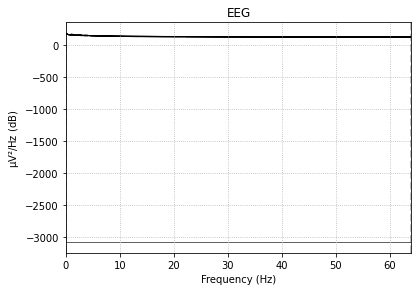

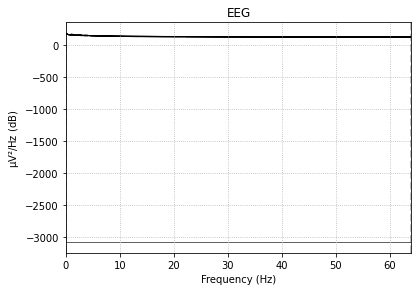

In [ ]:
# data = mne.time_frequency.psd_welch(raw_data)
# scale = dict(mag=1e-4) 
raw_data.plot_psd()

In [ ]:
hilb_picks = mne.pick_types(raw_data.info, meg=False, eeg=True)
raw_hilb = raw_data.copy()
raw_hilb.apply_hilbert(hilb_picks)
# amplitude = raw_hilb[0][0]
# print(amplitude.shape)

(1, 1612800)


In [ ]:
raw_amp = raw_hilb.copy()
raw_amp.apply_function(np.abs, hilb_picks)
# raw_phase = raw_hilb.copy()
# raw_phase.apply_function(np.angle, hilb_picks)
PSD = raw_amp[hilb_picks][0].real
PSD_array = np.array(PSD)
PSD_new = PSD_array.reshape(32,200,int(PSD_array.shape[1]/200))
PSD_reshape = PSD_new.reshape(PSD_new.shape[1], -1)
assert PSD_array.all() == PSD_reshape.all()
print(PSD_array.shape)
print(PSD_reshape.shape)

(32, 1612800)
(200, 258048)


In [ ]:
y_valance = y[:,0]
y_arousal = y[:,1]
y_dominance = y[:,2]
y_liking = y[:,3]
y_valance = y_valance[np.argsort(y_valance)]

In [ ]:
# def time_split(x,y):
data_3d = PSD_reshape.reshape(200,32,int(PSD_reshape.shape[1]/32))
data = np.empty(np.split(data_3d,8,axis=2)[0].shape)
for i in range (8):
    data = np.append(data,np.split(data_3d,8,axis=2)[i], axis = 0)
print(data.shape)

(1800, 32, 1008)


In [ ]:
def train_dev_test(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)
    # x_train, x_dev, y_train, y_dev = train_test_split(x_t1, y_t1, test_size = 0.2)
    params = {
        'x_train' : x_train,
        'y_train' : y_train,
        'x_test' : x_test,
        'y_test' : y_test
    }
    return params

In [ ]:
PSD_norm = (PSD_reshape - np.mean(PSD_reshape)) / np.std(PSD_reshape)
params = train_dev_test(PSD_norm,y_valance)

In [ ]:
# def linear_model_sgd(params, learning_rate, itteration):
x_train = params['x_train']
y_train = params['y_train']
y_test = params['y_test']
x_test = params['x_test']
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = model.score(x_test,y_test)
print(y_pred)
print(y_test)
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

[ 2.10041128e+238 -7.22099884e+238  1.41087564e+238 -2.36786489e+239
  1.44142292e+238  5.66654022e+237 -9.00897458e+239 -3.48585360e+238
  2.73156537e+237 -3.63730501e+238  2.24679212e+238 -1.17812427e+238
  4.38905425e+224  6.89639319e+240 -4.26573135e+237 -1.34704665e+238
  2.40702003e+239  4.38905425e+224  4.83786084e+239  3.76771953e+239]
[9.00000000e+000 4.92000000e+000 6.05000000e+000 4.44000000e+000
 7.08000000e+000 8.58000000e+000 9.00000000e+000 7.17000000e+000
 6.26000000e+000 6.36000000e+000 5.04000000e+000 7.00000000e+000
 6.92734778e-310 4.04000000e+000 8.01000000e+000 6.79000000e+000
 1.92000000e+000 6.92739144e-310 4.99000000e+000 5.97000000e+000]
Mean squared error: inf
Coefficient of determination: -inf


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:254: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


In [ ]:
print(y_pred)
print(y_valance)

[ 6.93094965e+02 -1.40523927e+05 -9.00270245e+04 -7.30435102e+05
  5.45053991e+04  6.48902245e+03 -2.44244314e+05 -2.53800869e+05
 -3.30370109e+05  4.88701287e+04  2.61042116e+04 -4.30161433e+05
 -1.77067106e+05 -4.62722616e+05  4.20166046e+04  1.06553339e+04
 -2.44970887e+05 -4.48474139e+05 -8.60710055e+04  1.64524418e+05
  3.30353833e+03 -1.69445987e+05 -2.67802466e+05 -1.91709465e+05
  7.35141682e+04  5.55344341e+02 -2.17273932e+05 -3.22130566e+05
 -2.27210975e+04  2.42119252e+05  1.03408333e+04 -2.28434020e+05
 -1.38327814e+06 -6.15219673e+04  8.65041205e+04  6.66608787e+03
 -2.71160496e+05 -2.90676841e+05 -2.72233553e+05  8.32223959e+04]
[1.36 1.95 1.99 2.06 2.08 2.28 2.28 2.31 2.46 2.71 2.9  2.99 3.03 3.17
 3.24 3.33 3.81 3.88 4.04 4.18 4.94 5.1  6.81 6.96 7.04 7.09 7.17 7.23
 7.28 7.32 7.35 7.44 7.71 8.1  8.15 8.26 8.27 8.58 8.86 9.  ]
